In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 64

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
train = torchvision.datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

Files already downloaded and verified


In [5]:
test = torchvision.datasets.CIFAR10(root = "./data", train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

Files already downloaded and verified


In [6]:
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Elige GPU si está disponible y CPU si no
device

device(type='cuda', index=0)

In [7]:
# device = "cpu"

In [8]:
for X, Y in train:
    print(X.shape)
    break

torch.Size([3, 32, 32])


In [9]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(*[
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride = 2),
            nn.ReLU(),
        ])
        self.decoder = nn.Sequential(*[
                nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride = 2, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, stride = 2, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, padding=1, stride = 2, output_padding=1),
                nn.Sigmoid()
        ])

    def forward(self, x):
        pred = self.encoder(x)
        pred = self.decoder(pred)
        return pred

In [10]:
model = AE()
model.to(device)

AE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [11]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss(reduction="mean")

In [12]:
test_batch, _ = iter(testloader).next()
test_batch.to(device);

In [13]:
test_batch.shape

torch.Size([64, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Época 1 -> Loss: (Train) 0.1502 (Val) 0.1455


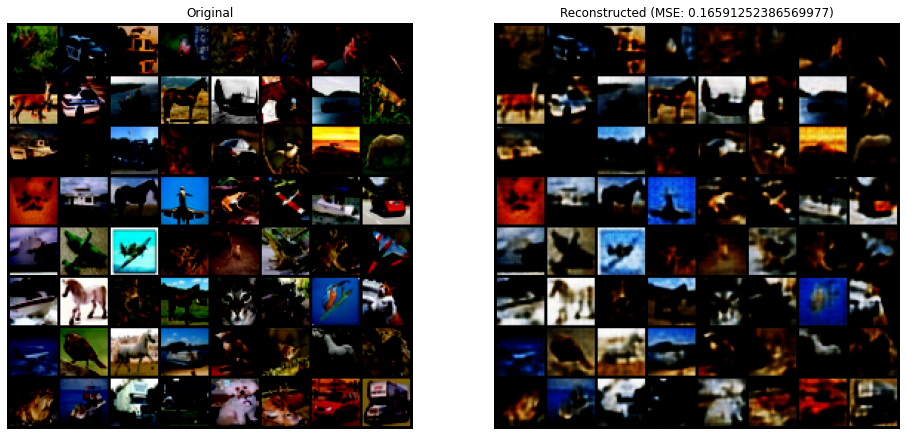

In [15]:
EPOCHS = 10

losses_train = []
losses_val = []

for epoch in range(EPOCHS):
    loss_batch_train = 0
    loss_batch_val = 0

    ##########
    #Training#
    ##########
    model.train()
    for X, Y in trainloader:
        X = X.to(device)
        
        optimizer.zero_grad()

        output = model(X)
        loss = loss_fn(output, X)
        loss.backward()
        optimizer.step()

        loss_batch_train += loss.cpu().item() * len(X)

    losses_train.append(loss_batch_train / len(train))
    # losses_train.append(loss_batch_train)
    
    ############
    #Validation#
    ############
    model.eval()
    for X_val, Y_val in testloader:
        X_val = X_val.to(device)

        with torch.no_grad():
            
            output_val = model(X_val)
            loss_val = loss_fn(output_val, X_val)
        loss_batch_val += loss_val.cpu().item() * len(X_val)

    losses_val.append(loss_batch_val / len(test))
    # losses_val.append(loss_batch_val)

    ############
    #Test_Batch#
    ############
    with torch.no_grad():
        test_batch = test_batch.to(device)
        pred_test = model(test_batch)
        test_loss = loss_fn(pred_test, test_batch)

    print(f"Época {epoch+1} -> Loss: (Train) {losses_train[-1]:.4f} (Val) {losses_val[-1]:.4f}")

    plt.figure(figsize=(16,16))
    grid1 = torchvision.utils.make_grid(test_batch.cpu(), nrow = int(np.sqrt(len(test_batch))))
    with torch.no_grad():
        grid2 = torchvision.utils.make_grid(pred_test.cpu(), nrow = int(np.sqrt(len(test_batch))))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(grid1.permute(1,2,0))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title(f"Reconstructed (MSE: {test_loss})")
    plt.imshow(grid2.cpu().permute(1,2,0))
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


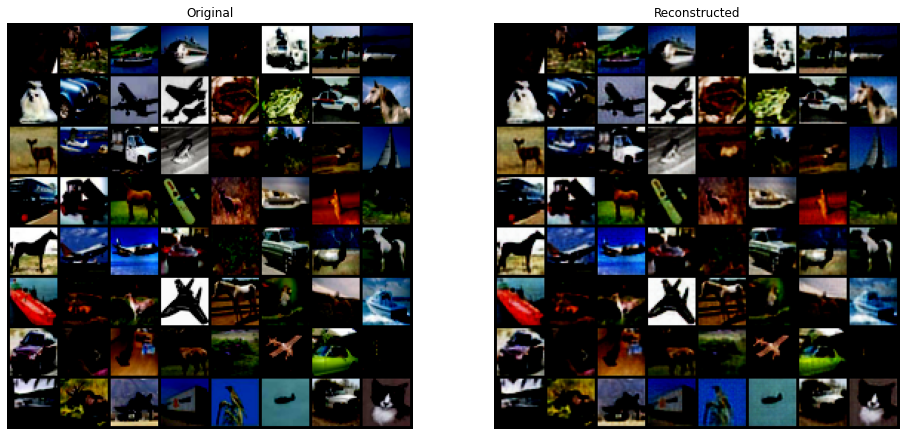

In [20]:
for X, Y in trainloader:
    plt.figure(figsize=(16,16))
    grid1 = torchvision.utils.make_grid(X, nrow = int(np.sqrt(len(X))))
    with torch.no_grad():
        grid2 = torchvision.utils.make_grid(model(X.to(device)), nrow = int(np.sqrt(len(X))))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(grid1.permute(1,2,0))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title("Reconstructed")
    plt.imshow(grid2.cpu().permute(1,2,0))
    plt.axis('off')
    plt.show()
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


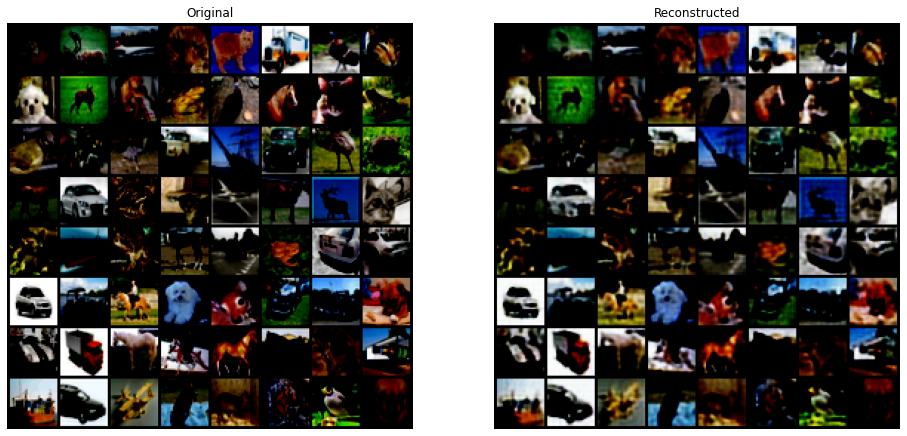

In [28]:
for X, Y in testloader:
    plt.figure(figsize=(16,16))
    grid1 = torchvision.utils.make_grid(X, nrow = int(np.sqrt(len(X))))
    with torch.no_grad():
        grid2 = torchvision.utils.make_grid(model(X.to(device)), nrow = int(np.sqrt(len(X))))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(grid1.permute(1,2,0))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title("Reconstructed")
    plt.imshow(grid2.cpu().permute(1,2,0))
    plt.axis('off')
    plt.show()
    break